# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from crypto_bot.utils import save_obj, load_obj, plot_roc

DATA_FOLDER = 'C:/Users/diego/crypto_bot/data'
WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

# Load data

In [2]:
full_ds_name = '{}/data_loaders/lgbm_15m_v1.ds'.format(DATA_FOLDER)

# Load
full_ds = load_obj(full_ds_name)
full_ds = full_ds.loc[:,~full_ds.T.duplicated(keep='first')]

train_dataset = full_ds[full_ds.Date < '2022-01-01']
valid_dataset = full_ds[full_ds.Date >= '2022-01-01']

In [3]:
train_dataset.shape

(136763, 39)

In [4]:
X_train, y_train = train_dataset[128:].copy(), train_dataset[128:].target24.copy().astype('int')
X_valid, y_valid = valid_dataset.copy(), valid_dataset.target24.copy().astype('int')

# Feature selection

In [87]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [104]:
random_forest = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=300,
    class_weight='balanced',
    max_depth=7,
    min_samples_split=20
)

In [105]:
boruta = BorutaPy(
    random_forest,
    n_estimators='auto',
    verbose=2,
    random_state=1,
    perc=100,
    max_iter=100
)

In [106]:
from sklearn.pipeline import Pipeline
from crypto_bot.model.transforms import DropFeatures, FeaturesImputer, ToFloatTransform, RegisterFeatures


drop = [
    'Date', 'Close', 'close_date',
    'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume', 'target8',
]

pipe = Pipeline([
    ('DROP_FEATURES', DropFeatures(drop)),
    ('IMPUTER', FeaturesImputer(features='all', strategy='constant', fill_value=0)),
    ('TO_FLOAT', ToFloatTransform()),
    ('FEATURES', RegisterFeatures(to_numpy=True)),
    ('MODEL', boruta)
])

In [107]:
pipe.fit(X_train.copy(), y_train.copy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	88
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	1
Rejected: 	62
Iteration: 	16 / 100
Confirmed: 	25
Tentative: 	1
Reject

Pipeline(steps=[('DROP_FEATURES',
                 DropFeatures(features=['Date', 'Close', 'close_date',
                                        'quote_asset_volume',
                                        'number_of_trades',
                                        'taker_buy_base_asset_volume',
                                        'taker_buy_quote_asset_volume',
                                        'target8'])),
                ('IMPUTER', FeaturesImputer(features='all')),
                ('TO_FLOAT', ToFloatTransform()),
                ('FEATURES', RegisterFeatures(to_numpy=True)),
                ('MODEL',
                 BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=7,
                                                           min_samples_split=20,
                                                           n_estimators=103,
                                                           n_

In [108]:
df_sel = pd.DataFrame({
    'name': pipe['FEATURES'].features,
    'top': pipe['MODEL'].support_,
    'weak': pipe['MODEL'].support_weak_
})
df_sel['low'] = ~(df_sel['top'] | df_sel['weak'])

In [109]:
pd.set_option('display.max_rows', 400)
fs_top = df_sel[df_sel.top == True].name.tolist() # mas relevantes
fs_weak = df_sel[df_sel.weak == True].name.tolist() # talvez relevantes
fs_low = df_sel[df_sel.low == True].name.tolist() # descartadas
fs_ext = df_sel[df_sel.low != True].name.tolist() # no descartadas

In [110]:
selected_features = fs_top + fs_weak

In [112]:
selected_features = [
    'Open',
    'High',
    'Low',
    'Volume',
    'bbands16_0',
    'bbands16_1',
    'bbands16_2',
    'bbands64_0',
    'bbands64_1',
    'bbands64_2',
    'sma5',
    'sma8',
    'sma13',
    'mama0',
    'mama1',
    'rsi6',
    'rsi14',
    'min_sma13_16',
    'min_sma13_64',
    'max_sma13_16',
    'max_sma13_64',
    'min_supsma_16',
    'min_ressma_16',
    'min_ressma_32',
]

# Define model

In [22]:
from lightgbm import LGBMClassifier


model = LGBMClassifier(
    num_leaves=18,
    max_depth=5,
    learning_rate=0.01,
    n_estimators=3000,
    class_weight='balanced',
    min_child_samples=300,
    subsample=0.5,
    colsample_bytree=0.5,
)

In [23]:
from sklearn.pipeline import Pipeline
from crypto_bot.model.transforms import DropFeatures, FeaturesImputer, ToFloatTransform, FilterFeatures


drop = [
    'Date', 'Close', 'close_date',
    'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume', 'target24',
     # 'Open', 'High', 'Low', 'Volume',
]

pipe = Pipeline([
    # ('FILTER_FEATURES', FilterFeatures(selected_features)),
    ('DROP_FEATURES', DropFeatures(features=drop)),
    ('IMPUTER', FeaturesImputer(features='all', strategy='constant', fill_value=0)),
    ('TO_FLOAT', ToFloatTransform()),
    ('MODEL', model)
])

# Train

In [24]:
pipe.fit(X_train.copy(), y_train.copy())

Pipeline(steps=[('DROP_FEATURES',
                 DropFeatures(features=['Date', 'Close', 'close_date',
                                        'quote_asset_volume',
                                        'number_of_trades',
                                        'taker_buy_base_asset_volume',
                                        'taker_buy_quote_asset_volume',
                                        'target24'])),
                ('IMPUTER', FeaturesImputer(features='all')),
                ('TO_FLOAT', ToFloatTransform()),
                ('MODEL',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.5,
                                learning_rate=0.01, max_depth=5,
                                min_child_samples=300, n_estimators=3000,
                                num_leaves=18, subsample=0.5))])

In [18]:
train_pred = pipe.predict_proba(X_train.copy())[:,1].flatten()
valid_pred = pipe.predict_proba(X_valid.copy())[:,1].flatten()

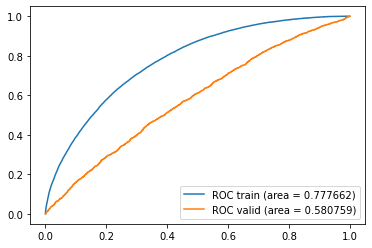

In [19]:
plot_roc({'train': (y_train, train_pred), 'valid': (y_valid, valid_pred)})

In [25]:
X_train['pred'] = train_pred
X_valid['pred'] = valid_pred

target24
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

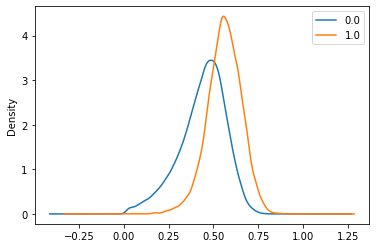

In [27]:
X_train.groupby('target24')['pred'].plot(kind='density', legend=True)

target24
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

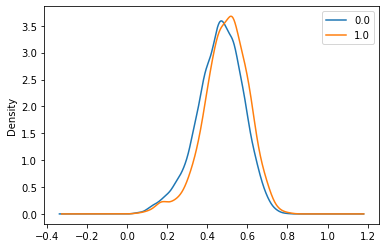

In [28]:
X_valid.groupby('target24')['pred'].plot(kind='density', legend=True)

In [58]:
X_valid[X_valid.pred > 0.55].target8.value_counts(normalize=True)

0.0    0.666667
1.0    0.333333
Name: target8, dtype: float64

In [86]:
X_valid[X_valid.pred > 0.6].target8.value_counts(normalize=True)

Series([], Name: target8, dtype: float64)

In [49]:
def find_threshold(ds, target_name, step=0.025, min_score=0.65):
    threshold = 0
    while threshold < 1:
        threshold += step
        segment = ds[ds.pred > threshold]
        if not len(segment):
            break
        distr = segment[target_name].value_counts(normalize=True)
        if 1 in distr and distr[1] > min_score:
            return threshold, distr[1]
    return None, None

def print_scores(ds, target_name, step=0.025, min_threshold=0.3, max_threshold=1):
    threshold = min_threshold
    while threshold < min(max_threshold, 1):
        segment = ds[ds.pred > threshold]
        if not len(segment):
            break
        distr = segment[target_name].value_counts(normalize=True)
        if 1 in distr:
            print('Th: {:.3f} Score: {:.3f} ({})'.format(threshold, distr[1], len(segment)))
        else:
            print('Th: {:.3f} Score:- ({})'.format(threshold, len(segment)))
        threshold += step

In [50]:
find_threshold(X_valid, 'target8')

(None, None)

In [103]:
print_scores(X_valid, 'target8', step=0.005, min_threshold=0.5)

Th: 0.500 Score: 0.223 (864)
Th: 0.505 Score: 0.228 (801)
Th: 0.510 Score: 0.239 (740)
Th: 0.515 Score: 0.242 (677)
Th: 0.520 Score: 0.245 (629)
Th: 0.525 Score: 0.243 (572)
Th: 0.530 Score: 0.247 (527)
Th: 0.535 Score: 0.247 (478)
Th: 0.540 Score: 0.256 (446)
Th: 0.545 Score: 0.274 (413)
Th: 0.550 Score: 0.277 (376)
Th: 0.555 Score: 0.275 (338)
Th: 0.560 Score: 0.283 (300)
Th: 0.565 Score: 0.290 (269)
Th: 0.570 Score: 0.295 (241)
Th: 0.575 Score: 0.315 (216)
Th: 0.580 Score: 0.303 (188)
Th: 0.585 Score: 0.291 (179)
Th: 0.590 Score: 0.280 (164)
Th: 0.595 Score: 0.283 (152)
Th: 0.600 Score: 0.285 (137)
Th: 0.605 Score: 0.298 (121)
Th: 0.610 Score: 0.306 (111)
Th: 0.615 Score: 0.333 (96)
Th: 0.620 Score: 0.301 (83)
Th: 0.625 Score: 0.254 (71)
Th: 0.630 Score: 0.233 (60)
Th: 0.635 Score: 0.220 (50)
Th: 0.640 Score: 0.213 (47)
Th: 0.645 Score: 0.209 (43)
Th: 0.650 Score: 0.257 (35)
Th: 0.655 Score: 0.300 (30)
Th: 0.660 Score: 0.321 (28)
Th: 0.665 Score: 0.250 (24)
Th: 0.670 Score: 0.238 (2

## Metrics

## Save model

In [157]:
save_obj(WEIGHTS_PATH + '/lgbm.pickle', pipe)

In [59]:
trainer.model(train_dataset[0][0].unsqueeze(0).float())[0].item()

float